# 0.2 Running a Basic Model on Combigen

In this notebook we're going to just run the combigen task designed in nb 0.1 on some more modern models.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Tue Feb 19 2019 02:07:35 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 27ae5caa9a4ed17be9b760b1ad28b7f3d90a5892
Git branch : resnet


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging
from functools import reduce

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [33]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf import constants

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [8]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger()

## The Combigen Task

Now that the task has been put together from nb 0.1, let's import the functionified version of it and start prepping for running the model.

First let's refresh our memory on the task.

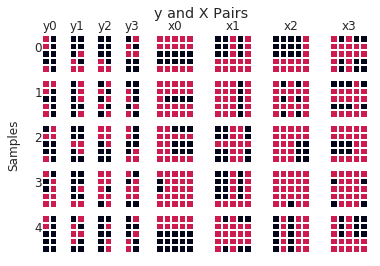

In [9]:
cgh.visualize_combigen(5)
plt.show()

Now that it works as expected, lets move back to setting up the data.

## O'Reily BP Model

Before working with anything close to state of the art (SOTA), a good place to start is with the backpropagation model that O'Reily used in his paper. It's described as a fully connected network with 100 hidden units, so let's put all that into a hyper-parameter variable.

Note: Instead of dictionaries to hold config-type data, I'm using `pdict`s from the [pstar](https://github.com/iansf/pstar) repo as mentioned in [this](https://danijar.com/patterns-for-fast-prototyping-with-tensorflow/) blog post.

In [82]:
# pdicts allow for attribute dictionary setting among other things
from pstar import pdict
# for the checkpoint path
from leabratf.constants import DIR_MODELS

hyper_params = pdict()

# Task parameters - see nb 0.1-0.1.2 for the experimental design
hyper_params.combigen_stack = 4
hyper_params.combigen_dims = 2
hyper_params.combigen_size = 5
# Stack number is currently not implemented, but will be for future analyses
# hyper_params.combigen_stack = 4
hyper_params.n_train = 500
hyper_params.n_test = 500

# Network parameters - see paper description
hyper_params.layer_size = 100
hyper_params.output_size = hyper_params[['combigen_stack', 'combigen_size', 'combigen_dims']]
hyper_params.output_units = reduce(lambda x,y: x*y, hyper_params.output_size)
hyper_params.activation = tf.nn.sigmoid

# Training parameters
hyper_params.learning_rate = 0.00003
hyper_params.batch_size = 1 
hyper_params.epochs = 10

# Experiment Parameters
hyper_params.save_weights = True
hyper_params.validation_iters = 1000

hyper_params.checkpoint_path = str(DIR_MODELS / 'checkpoints')

Let's put together an `input_fn` that will return a `dataset` object containing the features and labels.

In [83]:
# Define the input fn
def input_fn(mode, params):
    n_samples = params['n_train'] if mode==tf.estimator.ModeKeys.EVAL else params['n_test']
    
    y = cg.generate_labels(n_samples=n_samples,
                           stack=params['combigen_stack'],
                           size=params['combigen_size'],
                           dims=params['combigen_dims'])
    X = cg.inverse_transform(y)
    
    # Quick sanity checks
    assert X.shape[0] == y.shape[0] # Number of samples
    assert X.shape[1] == y.shape[1] # Stack
    assert X.shape[2] == y.shape[2] # Size
    assert X.shape[3] == y.shape[2] # Size

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(params['batch_size'])
    dataset = dataset.repeat(params['epochs'])
    iterator = dataset.make_one_shot_iterator()
    
    X, y = iterator.get_next()
    return X, y

Now we can start putting together the model.

In [84]:
def create_model_obp(input_tensor, mode, hyper_params):
    """Function that generates the the O'Reily backpropagation model."""
    model = pdict()
#      with tf.variable_scope("OBPDenseNet") as scope:
#         # Reuse the weights if we're evaling
#         if mode == tf.estimator.ModeKeys.EVAL:
#             scope.reuse_variables()
        #import ipdb; ipdb.set_trace()
        # Reshape the data accordingly
        # Single hidden layer
    
    x = tf.layers.dense(input_tensor, 
                        units=hyper_params['layer_size'], 
                        activation=hyper_params['activation'],
                        name='Dense1',
                        trainable=True)
    # Output layer
    model.logits = tf.layers.dense(x, 
                                   units=hyper_params['output_units'],
                                   activation=None,
                                   name='Linear1',
                                   trainable=True)
    model.probs = tf.nn.softmax(logits=model.logits, name='probs')
    return model

Next the loss.

In [85]:
def create_loss(model, labels, mode, hyper_params):
    """Function that returns the loss of a model on the labels."""
    metrics = pdict()
    
    y = tf.reshape(labels, [-1, hyper_params['output_units']], name='labels')
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=model.logits,
        labels=y,
    ))
    loss_name = str(mode) + '/loss'
    tf.summary.scalar(loss_name, loss_op)
    metrics.loss_name = loss_op
    
    return loss_op, metrics

Now put them together along with an optimizer to create `model_fn`

In [86]:
def model_fn(features, labels, mode, params):
    # Create the model
    model = create_model_obp(features, mode, params)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=model)
    
    # Create the loss operation
    loss, metrics = create_loss(model, labels, mode, params)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss) #, eval_metric_ops=metrics)
    
    # Define the optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope("optimizer"):
#             # Define a training operation
#             train_op = tf.train.AdamOptimizer(0.01)
#             train_op = tf.train.GradientDescentOptimizer(
#                 learning_rate=params['learning_rate']).minimize(loss, global_step=tf.train.get_global_step())
            train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    raise RuntimeError('Invalid mode entered, {})'.format(mode))

In [87]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
#         with tf.name_scope('stddev'):
#             stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
#         tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [88]:
global_step = tf.Variable(0)

model_dir = constants.DIR_MODELS

config = tf.estimator.RunConfig(model_dir=model_dir)

estimator = tf.estimator.Estimator(model_fn, params=hyper_params, config=config)
train_spec = tf.estimator.TrainSpec(input_fn=lambda:input_fn(tf.estimator.ModeKeys.TRAIN, hyper_params))
eval_spec = tf.estimator.EvalSpec(input_fn=lambda:input_fn(tf.estimator.ModeKeys.EVAL, hyper_params))

for var in tf.trainable_variables():
    variable_summaries(var)
merged_summary = tf.summary.merge_all()

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': '/home/apra/work/projects/leabra-tf/models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc17dbbe438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


2019-02-19 02:35:32 apra-xps13 tensorflow[18447] INFO Using config: {'_model_dir': '/home/apra/work/projects/leabra-tf/models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc17dbbe438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Running training and evaluation locally (non-distributed).


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Calling model_fn.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Calling model_fn.


INFO:tensorflow:Done calling model_fn.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Graph was finalized.


INFO:tensorflow:Restoring parameters from /home/apra/work/projects/leabra-tf/models/model.ckpt-10000


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Restoring parameters from /home/apra/work/projects/leabra-tf/models/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 10000 into /home/apra/work/projects/leabra-tf/models/model.ckpt.


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO Saving checkpoints for 10000 into /home/apra/work/projects/leabra-tf/models/model.ckpt.


INFO:tensorflow:loss = 72.63191, step = 10001


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO loss = 72.63191, step = 10001


INFO:tensorflow:global_step/sec: 1028.29


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO global_step/sec: 1028.29


INFO:tensorflow:loss = 66.91044, step = 10101 (0.101 sec)


2019-02-19 02:35:33 apra-xps13 tensorflow[18447] INFO loss = 66.91044, step = 10101 (0.101 sec)


INFO:tensorflow:global_step/sec: 547.634


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 547.634


INFO:tensorflow:loss = 91.52677, step = 10201 (0.186 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 91.52677, step = 10201 (0.186 sec)


INFO:tensorflow:global_step/sec: 1024.72


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 1024.72


INFO:tensorflow:loss = 88.40373, step = 10301 (0.096 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 88.40373, step = 10301 (0.096 sec)


INFO:tensorflow:global_step/sec: 1110.35


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 1110.35


INFO:tensorflow:loss = 47.151287, step = 10401 (0.086 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 47.151287, step = 10401 (0.086 sec)


INFO:tensorflow:global_step/sec: 1194.69


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 1194.69


INFO:tensorflow:loss = 73.49492, step = 10501 (0.085 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 73.49492, step = 10501 (0.085 sec)


INFO:tensorflow:global_step/sec: 621.598


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 621.598


INFO:tensorflow:loss = 66.86064, step = 10601 (0.164 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 66.86064, step = 10601 (0.164 sec)


INFO:tensorflow:global_step/sec: 613.79


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 613.79


INFO:tensorflow:loss = 84.27954, step = 10701 (0.159 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 84.27954, step = 10701 (0.159 sec)


INFO:tensorflow:global_step/sec: 1127.1


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 1127.1


INFO:tensorflow:loss = 85.750694, step = 10801 (0.089 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 85.750694, step = 10801 (0.089 sec)


INFO:tensorflow:global_step/sec: 798.764


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 798.764


INFO:tensorflow:loss = 48.59095, step = 10901 (0.126 sec)


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO loss = 48.59095, step = 10901 (0.126 sec)


INFO:tensorflow:global_step/sec: 1263.6


2019-02-19 02:35:34 apra-xps13 tensorflow[18447] INFO global_step/sec: 1263.6


INFO:tensorflow:loss = 76.39931, step = 11001 (0.081 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 76.39931, step = 11001 (0.081 sec)


INFO:tensorflow:global_step/sec: 1458.24


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1458.24


INFO:tensorflow:loss = 66.46165, step = 11101 (0.066 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 66.46165, step = 11101 (0.066 sec)


INFO:tensorflow:global_step/sec: 1180.26


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1180.26


INFO:tensorflow:loss = 82.807755, step = 11201 (0.085 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 82.807755, step = 11201 (0.085 sec)


INFO:tensorflow:global_step/sec: 577.214


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 577.214


INFO:tensorflow:loss = 85.64424, step = 11301 (0.177 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 85.64424, step = 11301 (0.177 sec)


INFO:tensorflow:global_step/sec: 784.403


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 784.403


INFO:tensorflow:loss = 49.340878, step = 11401 (0.124 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 49.340878, step = 11401 (0.124 sec)


INFO:tensorflow:global_step/sec: 1068.29


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1068.29


INFO:tensorflow:loss = 77.241714, step = 11501 (0.094 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 77.241714, step = 11501 (0.094 sec)


INFO:tensorflow:global_step/sec: 928.155


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 928.155


INFO:tensorflow:loss = 65.44937, step = 11601 (0.107 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 65.44937, step = 11601 (0.107 sec)


INFO:tensorflow:global_step/sec: 1420.46


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1420.46


INFO:tensorflow:loss = 82.06217, step = 11701 (0.073 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 82.06217, step = 11701 (0.073 sec)


INFO:tensorflow:global_step/sec: 1057.33


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1057.33


INFO:tensorflow:loss = 85.59954, step = 11801 (0.092 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 85.59954, step = 11801 (0.092 sec)


INFO:tensorflow:global_step/sec: 1097.58


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1097.58


INFO:tensorflow:loss = 49.98336, step = 11901 (0.091 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 49.98336, step = 11901 (0.091 sec)


INFO:tensorflow:global_step/sec: 1318.18


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO global_step/sec: 1318.18


INFO:tensorflow:loss = 77.86101, step = 12001 (0.075 sec)


2019-02-19 02:35:35 apra-xps13 tensorflow[18447] INFO loss = 77.86101, step = 12001 (0.075 sec)


INFO:tensorflow:global_step/sec: 1378.65


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1378.65


INFO:tensorflow:loss = 64.44015, step = 12101 (0.072 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 64.44015, step = 12101 (0.072 sec)


INFO:tensorflow:global_step/sec: 1395.18


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1395.18


INFO:tensorflow:loss = 81.81076, step = 12201 (0.072 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 81.81076, step = 12201 (0.072 sec)


INFO:tensorflow:global_step/sec: 1106.2


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1106.2


INFO:tensorflow:loss = 85.635666, step = 12301 (0.092 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 85.635666, step = 12301 (0.092 sec)


INFO:tensorflow:global_step/sec: 1355.32


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1355.32


INFO:tensorflow:loss = 50.551826, step = 12401 (0.072 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 50.551826, step = 12401 (0.072 sec)


INFO:tensorflow:global_step/sec: 1396.57


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1396.57


INFO:tensorflow:loss = 78.44942, step = 12501 (0.072 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 78.44942, step = 12501 (0.072 sec)


INFO:tensorflow:global_step/sec: 1516.04


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1516.04


INFO:tensorflow:loss = 63.61695, step = 12601 (0.070 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 63.61695, step = 12601 (0.070 sec)


INFO:tensorflow:global_step/sec: 1159.03


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1159.03


INFO:tensorflow:loss = 81.850395, step = 12701 (0.082 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 81.850395, step = 12701 (0.082 sec)


INFO:tensorflow:global_step/sec: 1563.15


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1563.15


INFO:tensorflow:loss = 85.7495, step = 12801 (0.064 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 85.7495, step = 12801 (0.064 sec)


INFO:tensorflow:global_step/sec: 1263.3


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1263.3


INFO:tensorflow:loss = 51.073723, step = 12901 (0.079 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 51.073723, step = 12901 (0.079 sec)


INFO:tensorflow:global_step/sec: 1429.27


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1429.27


INFO:tensorflow:loss = 79.0294, step = 13001 (0.070 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 79.0294, step = 13001 (0.070 sec)


INFO:tensorflow:global_step/sec: 1532.91


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1532.91


INFO:tensorflow:loss = 63.119194, step = 13101 (0.066 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 63.119194, step = 13101 (0.066 sec)


INFO:tensorflow:global_step/sec: 1522.22


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1522.22


INFO:tensorflow:loss = 82.009384, step = 13201 (0.065 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 82.009384, step = 13201 (0.065 sec)


INFO:tensorflow:global_step/sec: 1465.84


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO global_step/sec: 1465.84


INFO:tensorflow:loss = 85.896835, step = 13301 (0.068 sec)


2019-02-19 02:35:36 apra-xps13 tensorflow[18447] INFO loss = 85.896835, step = 13301 (0.068 sec)


INFO:tensorflow:global_step/sec: 1310.56


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1310.56


INFO:tensorflow:loss = 51.56066, step = 13401 (0.077 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 51.56066, step = 13401 (0.077 sec)


INFO:tensorflow:global_step/sec: 1440.41


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1440.41


INFO:tensorflow:loss = 79.59552, step = 13501 (0.073 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 79.59552, step = 13501 (0.073 sec)


INFO:tensorflow:global_step/sec: 1139.23


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1139.23


INFO:tensorflow:loss = 62.883293, step = 13601 (0.084 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 62.883293, step = 13601 (0.084 sec)


INFO:tensorflow:global_step/sec: 1475.6


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1475.6


INFO:tensorflow:loss = 82.16679, step = 13701 (0.068 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 82.16679, step = 13701 (0.068 sec)


INFO:tensorflow:global_step/sec: 1455.83


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1455.83


INFO:tensorflow:loss = 86.050064, step = 13801 (0.074 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 86.050064, step = 13801 (0.074 sec)


INFO:tensorflow:global_step/sec: 1112.66


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1112.66


INFO:tensorflow:loss = 52.01457, step = 13901 (0.091 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 52.01457, step = 13901 (0.091 sec)


INFO:tensorflow:global_step/sec: 1136.26


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1136.26


INFO:tensorflow:loss = 80.12685, step = 14001 (0.082 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 80.12685, step = 14001 (0.082 sec)


INFO:tensorflow:global_step/sec: 1464.31


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1464.31


INFO:tensorflow:loss = 62.771843, step = 14101 (0.068 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 62.771843, step = 14101 (0.068 sec)


INFO:tensorflow:global_step/sec: 1153.3


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 1153.3


INFO:tensorflow:loss = 82.29246, step = 14201 (0.087 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 82.29246, step = 14201 (0.087 sec)


INFO:tensorflow:global_step/sec: 540.76


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 540.76


INFO:tensorflow:loss = 86.20349, step = 14301 (0.190 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 86.20349, step = 14301 (0.190 sec)


INFO:tensorflow:global_step/sec: 742.707


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO global_step/sec: 742.707


INFO:tensorflow:loss = 52.434776, step = 14401 (0.130 sec)


2019-02-19 02:35:37 apra-xps13 tensorflow[18447] INFO loss = 52.434776, step = 14401 (0.130 sec)


INFO:tensorflow:global_step/sec: 1141.65


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO global_step/sec: 1141.65


INFO:tensorflow:loss = 80.62163, step = 14501 (0.088 sec)


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO loss = 80.62163, step = 14501 (0.088 sec)


INFO:tensorflow:global_step/sec: 1167.11


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO global_step/sec: 1167.11


INFO:tensorflow:loss = 62.70218, step = 14601 (0.086 sec)


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO loss = 62.70218, step = 14601 (0.086 sec)


INFO:tensorflow:global_step/sec: 1349.3


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO global_step/sec: 1349.3


INFO:tensorflow:loss = 82.40403, step = 14701 (0.074 sec)


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO loss = 82.40403, step = 14701 (0.074 sec)


INFO:tensorflow:global_step/sec: 1117.17


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO global_step/sec: 1117.17


INFO:tensorflow:loss = 86.35297, step = 14801 (0.100 sec)


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO loss = 86.35297, step = 14801 (0.100 sec)


INFO:tensorflow:global_step/sec: 675.61


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO global_step/sec: 675.61


INFO:tensorflow:loss = 52.83718, step = 14901 (0.139 sec)


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO loss = 52.83718, step = 14901 (0.139 sec)


INFO:tensorflow:Saving checkpoints for 15000 into /home/apra/work/projects/leabra-tf/models/model.ckpt.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Saving checkpoints for 15000 into /home/apra/work/projects/leabra-tf/models/model.ckpt.


INFO:tensorflow:Calling model_fn.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Calling model_fn.


INFO:tensorflow:Done calling model_fn.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-02-19-07:35:38


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Starting evaluation at 2019-02-19-07:35:38


INFO:tensorflow:Graph was finalized.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Graph was finalized.


INFO:tensorflow:Restoring parameters from /home/apra/work/projects/leabra-tf/models/model.ckpt-15000


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Restoring parameters from /home/apra/work/projects/leabra-tf/models/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2019-02-19 02:35:38 apra-xps13 tensorflow[18447] INFO Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2019-02-19-07:35:39


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Finished evaluation at 2019-02-19-07:35:39


INFO:tensorflow:Saving dict for global step 15000: global_step = 15000, loss = 75.44577


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Saving dict for global step 15000: global_step = 15000, loss = 75.44577


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: /home/apra/work/projects/leabra-tf/models/model.ckpt-15000


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Saving 'checkpoint_path' summary for global step 15000: /home/apra/work/projects/leabra-tf/models/model.ckpt-15000


INFO:tensorflow:Loss for final step: 72.04926.


2019-02-19 02:35:39 apra-xps13 tensorflow[18447] INFO Loss for final step: 72.04926.


({'loss': 75.44577, 'global_step': 15000}, [])

## Hints

Various hints for working on `jupyter notebooks`. Should probably be removed when a notebook is completed.

General stuff:
- To make logging even lazier, set `print = logger.info`, and then `print` away!
- The `!` can be used to run shell commands from within the notebook (ex. `!which conda`)
- Use `assert` liberally - this isn't a script and it's very readable.

Cheatsheets:
- [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)